# Some experiments with a loan dataset
We analyse labelled loan application data having 614 observations and 11 features applying supervised machine learning algorithms including neural nets. The data has been obtained from Analytics Vidhya. 


# Roadmap


Since the analysis is a bit lengthy, here is a roadmap.

After some EDA and data munging, we fit the standard classification models from scikitlearn like Logistic Regression, SVC, Linear SVC, Random Forest, KNN etc. We introduce some extra features that improve the performance a little bit. Feature importances (or coefficients) more or less conform to the EDA. Logistic, Linear SVC and Random Forest are the best performers.

However, all models suffer from a very weak recall score (about 0.45) for the class 0 (loan rejected). Two possible shortcomings may be: 1) Models not able to produce desired nonlinearlity of decision boundary or 2) Models having diffculty with noisy decison boundary, possibly aggravated by unbalanced classes ( 69 % approved versus 31 % rejected). 

Since Logistic and Linear SVC have performed better than SVC,  the second possiblity is more likely to be playing the spoiler. So we try the AdaBoost Classifier, which tries to recitify things by assigning higher weights to misclassified observations. We use Random Forest as the base classifer for AdaBoost. This has a good impact on recall score for class 0 (0.55), but precision for this class goes down(0.75) and f-1 score does not change(0.64). Weighted average of f1 is 0.80, better than our previous best of 0.79.

However, we know that neural networks are much better at discovering nonlinear decision boundaries. So to double-check, we build a neural net from scratch (with one hidden layer, He initialization, and the options of using Momentum or Adam optimizations). The net does not outperform Logistic Regression. Recall for class 0 is again 0.45.

We do a final experiment: We know that neural nets love bigger datasets. Can we adress the imbalance in the classes by producing a bigger and more balanced training set using random sampling with replacement? We carry this out. For class 0 we get recall=0.63, precision=0.65, f1=0.64. Weighted average of f1 is again 0.80. So this is as good as AdaBoost, and a bit more balanced even.




In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #setting default option for seaborn
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model


%matplotlib inline  

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

np.random.seed(2)

In [2]:
# Importing test data from same directory

test=pd.read_csv('test_Y3wMUE5_7gLdaTN.csv') 
df_test=pd.DataFrame(test)


# Importing train data from 

train=pd.read_csv('train_u6lujuX_CVtuZ9i.csv')
df=pd.DataFrame(train)




# Exploratory Data Analysis

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 43.2+ KB


We note that there are missing or null values in the Gender, Married, Dependents, Self_Employed, Loan_Amount, Loan_Amount_Term,
Credit_History columns. 

Before we deal with these, let us do some exploratory data analysis. 

In [5]:
print(df['Loan_Status'].value_counts())

Y    422
N    192
Name: Loan_Status, dtype: int64


We observe that about 69% of the loan applications were accepted.

Let us do some inspection of how the categorical features like  Gender, Married, Education, Self_Employed and Property_Area effect the success of the loan application.

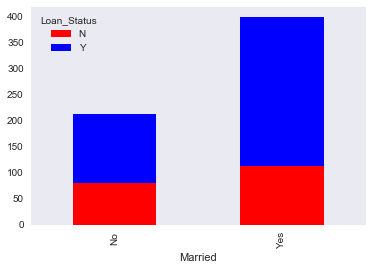

Percantage of successful Loan Applicants by Property_Area:
Loan_Status          N          Y
Married                          
No           37.089202  62.910798
Yes          28.391960  71.608040


In [6]:
temp = pd.crosstab(df['Married'], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)
plt.show()

total= (np.sum(temp, axis= 1))

print("Percantage of successful Loan Applicants by Property_Area:")
for col in list(temp.columns): 
        temp[col] = temp[col]/total * 100
    
print(temp)


Marital status seems to have some bearing on the success of loan application. What about Gender?

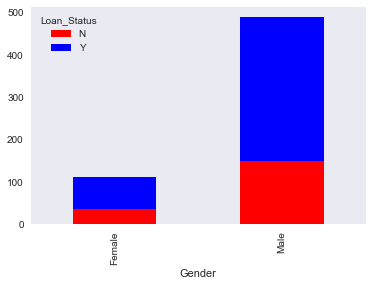

Percantage of successful Loan Applicants by Property_Area:
Loan_Status          N          Y
Gender                           
Female       33.035714  66.964286
Male         30.674847  69.325153


In [7]:
temp = pd.crosstab(df['Gender'], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)
plt.show()

total= (np.sum(temp, axis= 1))

print("Percantage of successful Loan Applicants by Property_Area:")
for col in list(temp.columns): 
        temp[col] = temp[col]/total * 100
    
print(temp)


Gender seems to have at most a small effect on Loan_Status. Let's check on Education next.

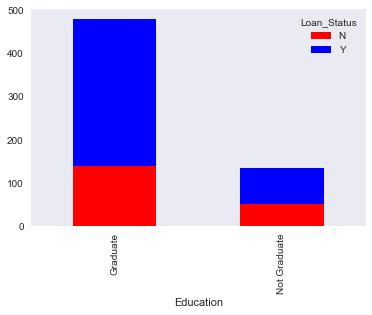

Percantage of successful Loan Applicants by Gender:
Loan_Status           N          Y
Education                         
Graduate      29.166667  70.833333
Not Graduate  38.805970  61.194030


In [8]:
temp = pd.crosstab(df['Education'], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)
plt.show()

total= (np.sum(temp, axis= 1))

print("Percantage of successful Loan Applicants by Gender:")
for col in list(temp.columns): 
        temp[col] = temp[col]/total * 100
    
print(temp)

Education seems to have a significant effect on Loan_Status. But, what about Property_Area?

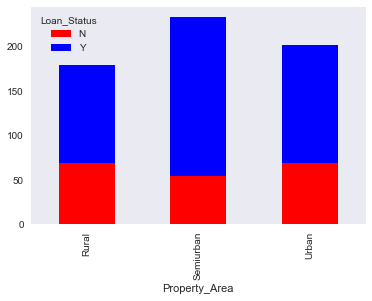

Loan_Status     N    Y
Property_Area         
Rural          69  110
Semiurban      54  179
Urban          69  133
Percantage of successful Loan Applicants by Property_Area:
Loan_Status            N          Y
Property_Area                      
Rural          38.547486  61.452514
Semiurban      23.175966  76.824034
Urban          34.158416  65.841584


In [9]:
temp = pd.crosstab(df['Property_Area'], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)
plt.show()

print(temp)

total= (np.sum(temp, axis= 1))

print("Percantage of successful Loan Applicants by Property_Area:")
for col in list(temp.columns): 
        temp[col] = temp[col]/total * 100
    
print(temp)


Property_Area seems to have considerable effect on Loan_Status. Note that semiurban properties have much higher success rate than urban or rural properties.

Let us check on the effect of Employment type. 

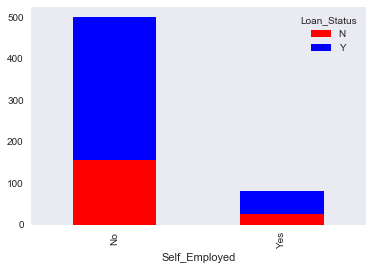

Percantage of successful Loan Applicants by Employment type:
Loan_Status            N          Y
Self_Employed                      
No             31.400000  68.600000
Yes            31.707317  68.292683


In [10]:
temp = pd.crosstab(df['Self_Employed'], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)
plt.show()

total= (np.sum(temp, axis= 1))

print("Percantage of successful Loan Applicants by Employment type:")
for col in list(temp.columns): 
        temp[col] = temp[col]/total * 100
    
print(temp)

We observe that Employment type has almost no effect on Loan_Status.

# Data wrangling and some more EDA:


Before we proceed to fit some machine learning models to the data, we need to clean it up. 

We have talked earlier about missing values. Since the percentage of missing values for each feature is reasonably low, we may hope to fill these out with some average value of the feature without distorting the data too much. We use mode for the categorical variables, and median for the numerical ones.

In [11]:
#Missing values

misslist=['Gender', 'Married', 'Dependents', 'Self_Employed',  'Credit_History']

for var in misslist:
    df[var].fillna(df[var].mode()[0], inplace=True)

df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(), inplace=True)


Scikitlearn machine learning algorithms accept only numerical inputs. So we are going to convert all catergorical entries into numerical ones. We use the LabelEncoder package of scikitlearn.


In [12]:
#Categorical Values to numeric

from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender','Married','Dependents','Education','Self_Employed', 'Loan_Status']

le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])

We deal with the Property_Area column separately as it has 3 different categories LabelEncoder would 
assign them values 0, 1, and 2. However there is no justification why the value of a category 
'Urban' be double of another 'Semiurban'. It is better to create independent features for these categories. We do this using 'get_dummies' function of pandas.  

In [13]:
#Categorical Values to numeric continued

df.Property_Area = df.Property_Area.astype('category')

#using pandas get_dummies function for the Property_Area column as it has multiple labels

dummies=pd.get_dummies(df[['Property_Area']])
dummies.head()

,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [14]:
# incorporating only two of the 3 dummy columns to ensure linear independence

df['Property_Area_Rural'] = dummies['Property_Area_Rural']
df['Property_Area_Urban'] = dummies['Property_Area_Urban']

#dropping the now redundant categorical Property_Area column

df = df.drop('Property_Area', axis=1)

Let us check out the data types of the various features.

In [15]:

df.dtypes 


Loan_ID                 object
Gender                   int32
Married                  int32
Dependents               int32
Education                int32
Self_Employed            int32
ApplicantIncome          int64
CoapplicantIncome      float64
LoanAmount             float64
Loan_Amount_Term       float64
Credit_History         float64
Loan_Status              int32
Property_Area_Rural      uint8
Property_Area_Urban      uint8
dtype: object

Let us examine the correlation between all variables using the heatmap function of seaborn.

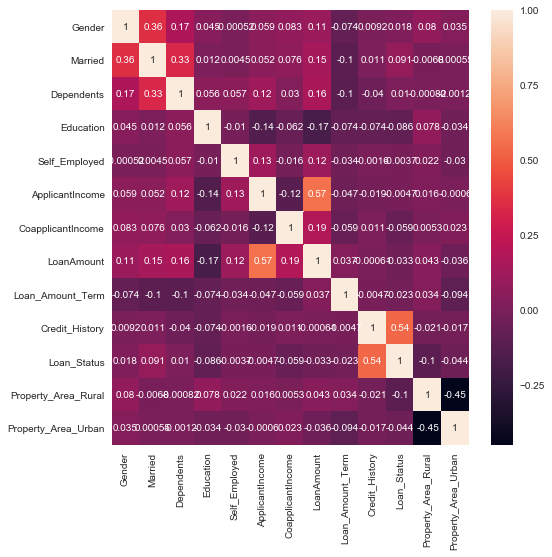

In [16]:
#Heatmap of correlation coefficients

sns.heatmap(df.corr(),annot=True)
fig = plt.gcf()
fig.set_size_inches(8,8)


Credit_History seems to be highly correlated with Loan_Status. The other variables having relatively nontrivial correlation with Loan_Status are Property_Area_Rural, Education and Married (marital status): as is to be expected from our bar plots. 

It is a bit surprising to see that none of the numerical features like ApplicantIncome has a significant correlation with Loan_Status. Is Loan_Status correlated to the sum of Applicant and Coapplicant incomes?



In [17]:
TotalIncome= df['ApplicantIncome'] + df['CoapplicantIncome']
print(np.corrcoef(TotalIncome, df['Loan_Status'] )[0,1])

-0.0312707788727


Nah!! Let us take a closer look at the distribution of the variables.

In [18]:
df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Urban
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.817590,0.653094,0.744300,0.218241,0.133550,5403.459283,1621.245798,145.752443,342.410423,0.855049,0.687296,0.291531,0.328990
std,0.386497,0.476373,1.009623,0.413389,0.340446,6109.041673,2926.248369,84.107233,64.428629,0.352339,0.463973,0.454838,0.470229
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,2877.500000,0.000000,100.250000,360.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,3812.500000,1188.500000,128.000000,360.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,5795.000000,2297.250000,164.750000,360.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000,1.000000,1.000000,1.000000


It is apparent that the features ApplicantIncome, CoapplicantIncome and LoanAmount have very high variance caused by 
extremely high outlying values. Look at the box plot of the LoanAmount column below for instance. 

Such outliers affect the performance of machine learning algorithms in a detrimental way. So we will perform a logarithmic 
transformation on these to make them more amenable.

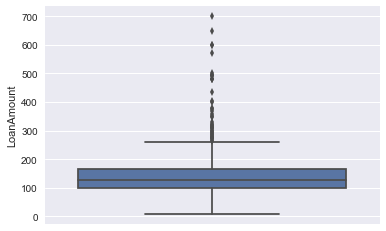

In [19]:
sns.boxplot(y='LoanAmount', data=df)

In [20]:
df['AI_log'] = np.log(df['ApplicantIncome']+1)
df['CAI_log'] = np.log(df['CoapplicantIncome']+1)
df['LA_log'] = np.log(df['LoanAmount'])

df[['AI_log', 'CAI_log', 'LA_log']].describe()

,AI_log,CAI_log,LA_log
count,614.000000,614.000000,614.000000
mean,8.341510,4.290129,4.857250
std,0.645035,3.875873,0.495996
min,5.017280,0.000000,2.197225
25%,7.965024,0.000000,4.607658
50%,8.246303,7.081125,4.852030
75%,8.664922,7.739897,5.104426
max,11.302217,10.637489,6.551080


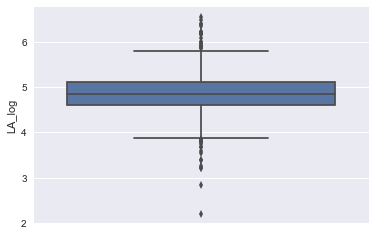

In [21]:
sns.boxplot(y='LA_log', data=df)

Finally we shift and scale every feature to mean zero and unit variance. This will improve the performance of the learning algorithms.

In [22]:
Y= df["Loan_Status"]
X= df.drop(["Loan_ID", 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', "Loan_Status"], axis = 1)


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))



# Fitting various models from Scikitlearn


We now define a function that we can easily call upon to split the data into test and train sets, fit a model, compute accuracy and cross validation scores and also display importance or weight of various features in the model.

In [23]:
def modelfit(clf, feature_wt = False, feature_imp = False, cv_folds=5):
    
    X_train,X_test,Y_train,Y_test = train_test_split(X_scaled, Y, stratify= Y, test_size=0.2, random_state = 2)

    
    clf.fit(X_train, Y_train)
    print('Model score: ' + str(clf.score(X_train, Y_train )) )
    
    Y_pred=clf.predict(X_test)

    print(classification_report(Y_test, Y_pred))

    
   
    
    if feature_wt:
        
        print('Logistic Reg coefficients: {}'.format(clf.coef_ ) )
        ind = X.columns
        coefs = clf.coef_
        ### coef = pd.DataFrame(clf.coef_ )
        ### coef.columns= ind
        ### coef.plot(kind='bar', title = 'Feature Weights')
        
         
        plt.bar(ind, np.squeeze(coefs) )
        plt.xticks(ind, rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Logistic Reg coefficients')
        

    
    elif feature_imp:
        feature_importance = pd.Series(clf.feature_importances_, X.columns).sort_values(ascending=False)
        feature_importance.plot(kind='bar', title = 'Feature Importances')
                                           

    cv_score = cross_val_score(clf, X_scaled, Y, cv=cv_folds, scoring='roc_auc')
    mean_cv = np.mean(cv_score)
    print('CV_auc:' + str(cv_score))
    print('Mean CV_auc: ' + str(mean_cv))
    
    cv_score = cross_val_score(clf, X_scaled, Y, cv=cv_folds, scoring='accuracy')
    mean_cv = np.mean(cv_score)
    print('CV_accuracy:' + str(cv_score))
    print('Mean CV_accuracy: ' + str(mean_cv))
    
                                       


We will first try to fit the logistic regression model to the data. Note that the standard version of logistic regression is L2 regularized.


Model score: 0.812627291242
             precision    recall  f1-score   support

          0       0.81      0.45      0.58        38
          1       0.79      0.95      0.87        85

avg / total       0.80      0.80      0.78       123

Logistic Reg coefficients: [[-0.19928743  0.29760389  0.0938355  -0.14319958  0.03644102 -0.07139349
   1.44376874 -0.34697729 -0.19590268  0.19801877  0.25600823 -0.3010327 ]]
CV_auc:[ 0.80482655  0.71493213  0.75532581  0.82424812  0.69423559]
Mean CV_auc: 0.758713639302
CV_accuracy:[ 0.81451613  0.76612903  0.79508197  0.85245902  0.81967213]
Mean CV_accuracy: 0.809571655209


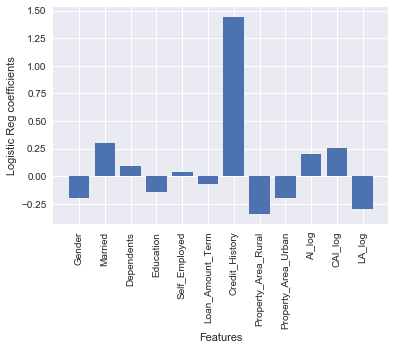

In [24]:
lr = LogisticRegression()
modelfit(lr, feature_wt=True)

A model accuracy of 81% with a mean cross validation accuracy of 80.95% is not bad! Roc_auc CV score is a healthy 0.7587. But a recall score of 45% for the 0 class suggests a problem: a bias towards the positive class.

Otherwise the weights of the different features seem to generally coorborate our intuition from the exploratory data analysis: Credit_History is very influential. Property_Area's (Rural and Urban) appear prominently with negative signs - this makes sense as they should balance the relative positive effect of (the absent) Property_Area_Suburban. We happily note that the logarithmic incomes and loan amounts are pulling their weights in the right directions. 

The only surprise is the less than anticipated showing of Education (compared to Gender for instance) and that Self_Employed plays a part too!

And why is Depenedents having a positive effect?!

I did try dropping these two features, Self_Employed and Dependendents, but that did not improve matters.

Let us see if a Decison Tree Classifier does better. It is palusible that a tree like decison making process may indeed be involved in loan approval. 

Model score: 0.828920570265
             precision    recall  f1-score   support

          0       0.81      0.45      0.58        38
          1       0.79      0.95      0.87        85

avg / total       0.80      0.80      0.78       123

CV_auc:[ 0.75505279  0.56877828  0.65068922  0.77631579  0.75454261]
Mean CV_auc: 0.701075737988
CV_accuracy:[ 0.80645161  0.73387097  0.78688525  0.85245902  0.83606557]
Mean CV_accuracy: 0.803146483342


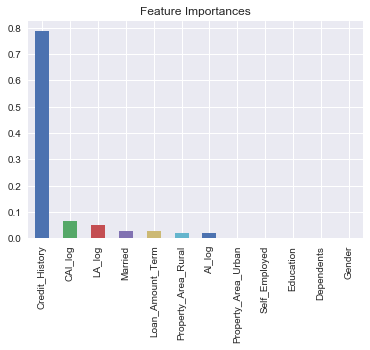

In [25]:
from sklearn.tree import DecisionTreeClassifier
tree= DecisionTreeClassifier(max_depth = 4)
modelfit(tree, feature_imp=True)

Hmm... not as good as logistic ! Well, it is known that Decision Tree is a top-greedy algorithm. Let us try the more reputable 
Random Forest.

Model score: 0.812627291242
             precision    recall  f1-score   support

          0       0.85      0.45      0.59        38
          1       0.80      0.96      0.87        85

avg / total       0.81      0.80      0.78       123

CV_auc:[ 0.80120664  0.66395173  0.7481203   0.78978697  0.75877193]
Mean CV_auc: 0.752367513807
CV_accuracy:[ 0.81451613  0.75806452  0.78688525  0.86065574  0.81967213]
Mean CV_accuracy: 0.807958751983


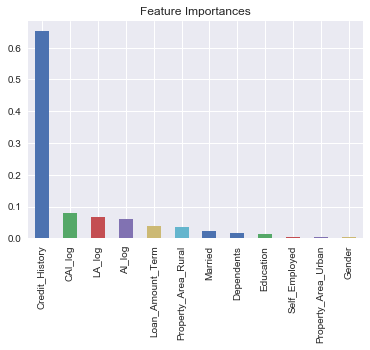

In [26]:
rf=RandomForestClassifier(n_estimators=1000, max_depth=3, max_features=4, random_state=2)
modelfit(rf, feature_imp=True)

Ah! Random Forest loses out to Logistic Regression on both accuracy and AUC CV scores by a hair's breadth!

In [27]:
svc = svm.SVC()
modelfit(svc)

Model score: 0.822810590631
             precision    recall  f1-score   support

          0       0.85      0.45      0.59        38
          1       0.80      0.96      0.87        85

avg / total       0.81      0.80      0.78       123

CV_auc:[ 0.7453997   0.67662142  0.81046366  0.80012531  0.69266917]
Mean CV_auc: 0.7450558523
CV_accuracy:[ 0.81451613  0.76612903  0.78688525  0.8442623   0.81967213]
Mean CV_accuracy: 0.806292966684


So SVC, which is good at coming up with a nonlinear decision boundary, does a good job too!
But how much would we lose if we used SVC with linear decision boundary? Let us try LinearSVC and find out.

In [28]:
linsvc = svm.LinearSVC()
modelfit(linsvc)

Model score: 0.810590631365
             precision    recall  f1-score   support

          0       0.85      0.45      0.59        38
          1       0.80      0.96      0.87        85

avg / total       0.81      0.80      0.78       123

CV_auc:[ 0.80392157  0.71402715  0.75689223  0.82393484  0.69486216]
Mean CV_auc: 0.758727588201
CV_accuracy:[ 0.81451613  0.76612903  0.78688525  0.86065574  0.81967213]
Mean CV_accuracy: 0.809571655209


Surprise, surprise! Linear SVC does better than SVC. Actually CV scores are as good as Logistic Regression.

In [29]:
knn=KNeighborsClassifier(n_neighbors=7)
modelfit(knn)

Model score: 0.822810590631
             precision    recall  f1-score   support

          0       0.77      0.45      0.57        38
          1       0.79      0.94      0.86        85

avg / total       0.79      0.79      0.77       123

CV_auc:[ 0.71297134  0.5907994   0.69423559  0.77380952  0.66525689]
Mean CV_auc: 0.687414548815
CV_accuracy:[ 0.7983871   0.75        0.76229508  0.80327869  0.77868852]
Mean CV_accuracy: 0.778529878371


KNeighbors slips up in the CV score.

To summarize all the models have a comparable f1 score of 0.78 (or 0.77 in case of KNeighbors). Logistic Regression and Linear SVC have the best cross validation scores of followed closely behind by Random Forest. All models suffer from a poor recall score of about 0.45 for the 0 class. 



# Feature Selection

We will next check out if the performance improves if we put some additional features in the mix. These features are quite intuitive ratios of given features. For example it is quite possible that rather than a linear combination of income and dependents, the ratio of these may be more pertinent in determining Loan_Status. However, Logistic Regression would not consider such a nonlinear function of the features.

We will look at the distributional aspects of these new features and take their logarithm if necessary. But we make sure that that the set of features remain linearly independent. Finally the features we add are: log of Total Income, log of Applicant Income to Number of Dependents ratio, log of Total Income to Number of Dependents ratio, and Loan Amount to Loan Amount Term ratio.


In [30]:
#feature selection

df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

df['LA_LAT_ratio'] =df['LoanAmount']/df['Loan_Amount_Term']

df['AI_D_ratio'] = df['ApplicantIncome']/ (df['Dependents'] +1) 

df['TI_D_ratio'] = df['TotalIncome']/( df['Dependents'] + 1 )

df[[ 'TotalIncome', 'LA_LAT_ratio', 'AI_D_ratio', 'TI_D_ratio' ]].describe()


,TotalIncome,LA_LAT_ratio,AI_D_ratio,TI_D_ratio
count,614.000000,614.000000,614.000000,614.000000
mean,7024.705081,0.473687,3833.354777,5024.998187
std,6458.663872,0.511134,4319.732743,4757.062214
min,1442.000000,0.025000,70.000000,457.500000
25%,4166.000000,0.288889,1734.875000,2354.375000
50%,5416.500000,0.361111,2777.666667,4166.000000
75%,7521.750000,0.505556,4327.750000,6000.000000
max,81000.000000,9.250000,63337.000000,63337.000000


It would help to take log of TotalIncome, AI_D_Ratio, and TI_D_ratio.

In [31]:
df['TI_log'] = np.log(df['TotalIncome'])
df['AI_D_ratio_log'] = np.log(df['AI_D_ratio'] )
df['TI_D_ratio_log'] = np.log(df['TI_D_ratio'])


In [32]:
X['TI_log']= df['TI_log']
X['AI_D_ratio_log'] = df['AI_D_ratio_log']
X['TI_D_ratio_log'] = df['TI_D_ratio_log']
X['LA_LAT_ratio'] = df['LA_LAT_ratio']

In [33]:
X_scaled = pd.DataFrame(scaler.fit_transform(X))

Model score: 0.816700610998
             precision    recall  f1-score   support

          0       0.82      0.47      0.60        38
          1       0.80      0.95      0.87        85

avg / total       0.81      0.80      0.79       123

Logistic Reg coefficients: [[-0.23442543  0.29698991  0.45268708 -0.1704154   0.05558223 -0.19270508
   1.46708758 -0.34854385 -0.17241257  0.08799861  0.41405556 -0.11449918
  -0.44105524  0.45580723  0.08055372 -0.14252309]]
CV_auc:[ 0.8015083   0.69110106  0.75971178  0.83051378  0.68953634]
Mean CV_auc: 0.754474251239
CV_accuracy:[ 0.81451613  0.75806452  0.78688525  0.85245902  0.81147541]
Mean CV_accuracy: 0.804680063458


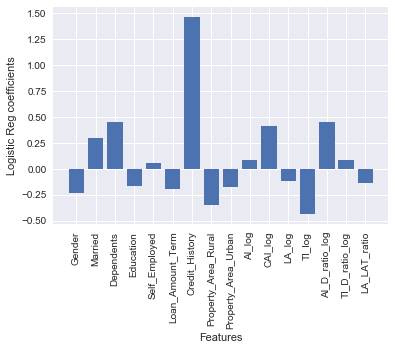

In [34]:
modelfit(lr, feature_wt=True)

Model score: 0.816700610998
             precision    recall  f1-score   support

          0       0.86      0.47      0.61        38
          1       0.80      0.96      0.88        85

avg / total       0.82      0.81      0.79       123

CV_auc:[ 0.78129713  0.70588235  0.77631579  0.7797619   0.76409774]
Mean CV_auc: 0.761470985155
CV_accuracy:[ 0.81451613  0.75806452  0.78688525  0.85245902  0.81967213]
Mean CV_accuracy: 0.806319407721


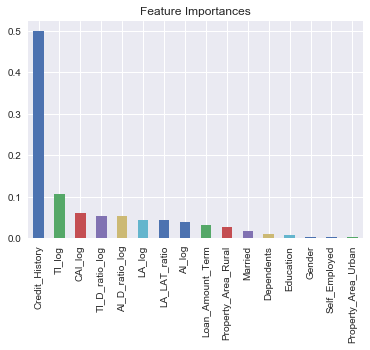

In [35]:
modelfit(rf, feature_imp=True)

In [36]:
modelfit(linsvc)

Model score: 0.81466395112
             precision    recall  f1-score   support

          0       0.86      0.47      0.61        38
          1       0.80      0.96      0.88        85

avg / total       0.82      0.81      0.79       123

CV_auc:[ 0.80633484  0.67300151  0.7518797   0.82612782  0.69172932]
Mean CV_auc: 0.749814638406
CV_accuracy:[ 0.81451613  0.76612903  0.78688525  0.86065574  0.81147541]
Mean CV_accuracy: 0.807932310947


Umm, the performance of our two most successful models, Logistic Regression and Random Forest, do not show much improvement due to the new features. f1-score goes up from 0.78 to 0.79 but mean CV score goes down a little.

However, Random Forest achieves a AUC mean CV score of 0.76147 (and an f1 score of 0.79). This is the best performance by a model so far. It also gives relatively high importance to all the features that we added!!

However, as the recall score for class 0 remains a lowly 0.47, let us see if the AdaBoostClassifier can help. AdaBoost works by increasing the weight of misclassified observations in the loss function. We use Random Forest as the base classifier.

In [42]:
from sklearn.ensemble import AdaBoostClassifier


clf = AdaBoostClassifier(n_estimators = 50, base_estimator= rf, learning_rate = 0.5, random_state=2)
modelfit(clf)

Model score: 0.955193482688
             precision    recall  f1-score   support

          0       0.75      0.55      0.64        38
          1       0.82      0.92      0.87        85

avg / total       0.80      0.80      0.80       123

CV_auc:[ 0.80090498  0.65248869  0.75626566  0.80764411  0.73057644]
Mean CV_auc: 0.749575976139
CV_accuracy:[ 0.75806452  0.74193548  0.78688525  0.81147541  0.78688525]
Mean CV_accuracy: 0.777049180328


Not bad! The recall score of class 0 has gone up to 0.55, and oevrall f1-score is at its best value of 0.80. However mean CV scores have suffered by a percent or two. 

# Neural Networks

We know that neural networks are much better at figuring out nonlinear decision boundaries than Logistic Regression. So why not try one out to see if we can improve the fit. Instead of using some package, I will build a neural net with one hidden layer (and momentum optimization) by hand just for fun (and pratice). If you are bored you may gloss over the details until we come to the output part.

For the technically minded, we are going to use He Initialization and Batch Gradient Descent. Our default option will use Momentum Optimization. But we can use ADAM optimization if we want. (With our dataset, I found that ADAM to be converging too fast, and a bit hard to control with parameter tuning.)

# Constructing the 2 layer nn

In [38]:
# Function: sigmoid(). Turns a matrix "z" of real numbers into a matrix "a" of probabilities 

def sigmoid(z):
    s=1/(1+np.exp(-z))
    return s

In [39]:
# Function: initialize_parameters

def initialize_parameters(n_x, n_h):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
   
    
    Returns:
    parameters -- python dictionary containing the parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (1, n_h)
                    b2 -- bias vector of shape (1, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    
    W1 = np.random.randn(n_h, n_x) * np.sqrt(2/n_x)
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(1, n_h) * np.sqrt(2/n_h)
    b2 = np.zeros((1, 1))
   
    
    
    parameters = {"W1": W1, "b1": b1, "W2": W2,  "b2": b2}
                  

    return parameters



In [40]:
# FUNCTION: initialize_moments

""" 
Argument:
none

Returns: 
Initialized moving averages of gradients VdWi, Vdbi, i=1,2.

"""

def initialize_moments():
    VdW1 =0
    Vdb1 =0
    VdW2 =0
    Vdb2 =0
    
    moments = {"VdW1": VdW1,  "Vdb1": Vdb1,  "VdW2": VdW2, "Vdb2": Vdb2}            
    
    return moments
    

In [41]:
# FUNCTION: initialize_S
# initializes RMS parameters

""" 
Argument:
none

Returns: 
Initialized moving averages of RMS parameters SdWi, Sdbi, i=1,2.

"""

def initialize_S():
    SdW1 =0
    Sdb1 =0
    SdW2 =0
    Sdb2 =0
    
    S = {"SdW1": SdW1,  "Sdb1": Sdb1,  "SdW2": SdW2, "Sdb2": Sdb2}            
    
    return S
    

In [42]:
#  Function: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m) where m equals the number of examples
    parameters -- python dictionary containing the parameters Wi, bi
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
   
    
    
    # Python Broadcasting is somehow not working properly on my Jupiter kernel. So need to do by hand.
    B1 = np.zeros(b1.shape)
    for i in range(b1.shape[1]):
        B1[:, i] = np.squeeze(b1)
    B2 = np.zeros(b2.shape)
    for i in range(b1.shape[1]):
        B2[:, i] = np.squeeze(b2) 
    
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    
    T1 = np.dot(W1, X)    
    Z1 = T1 + B1
    A1 = np.tanh(Z1)
    
    T2 = np.dot(W2, A1) 
    Z2 = T2 + B2
    A2 = sigmoid(Z2)

    
    assert(Z1.shape == (W1.shape[0], X.shape[1]))
    assert(Z2.shape == (W2.shape[0], X.shape[1]))
    assert(A2.shape == (1, X.shape[1]))
    
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
                      
    
    return A2, cache

In [43]:
#  FUNCTION: compute_cost

def compute_cost(A2, Y, parameters, lambd = 0):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy or log-loss cost 
    """

    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
  
    logprobs = np.array([np.multiply(np.log(A2),Y), np.multiply(np.log(1-A2),1-Y)])
    cost_entropy = - np.sum(logprobs)/m
    cost_regular = (np.sum(np.square(W1)) + np.sum(np.square(W2)) ) * (lambd/(2*m))
    cost = cost_entropy + cost_regular
   
    
    cost = np.squeeze(cost)      
    
    return cost


In [44]:
#  FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y, lambd=0):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters Wi, bi, i=1,2
    cache -- a dictionary containing Zi, Ai,  i=1,2
    X -- input data of shape (n_x, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing gradients Dwi, dbi 
    """
    m = X.shape[1]
    
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    
    A1 = cache["A1"]
    A2 = cache["A2"]
   
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    
    dZ2 = A2-Y
    dW2 = (1/m) * np.dot(dZ2, A1.T) + (lambd/m)*W2
    db2 = pd.DataFrame((1/m) * np.sum(dZ2, axis=1))
   
    
    dZ1 = np.outer(W2.T, dZ2) * (1 - A1*A1)
    dW1 = (1/m) * np.dot(dZ1, X.T) + (lambd/m)*W1 
    db1 = pd.DataFrame((1/m) * np.sum(dZ1, axis=1))

    
    assert (db2.shape == (dZ2.shape[0], 1))
    assert (db1.shape == (dZ1.shape[0], 1))
    assert (dW1.shape == W1.shape)
    assert (dW2.shape == W2.shape)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
             

    return grads


In [45]:
# FUNCTION: update_parameters

def update_parameters(parameters, grads, moments, learning_rate = 0.5, decay_rate=0.00005, beta=0.9, it_num = 0):
    """
    Updates parameters using the gradient descent with momentum optimization  
    
    Arguments:
    parameters -- python dictionary containing  parameters Wi,bi,  i=1,2
    grads -- python dictionary containing gradients dWi, dbi,  i=1,2
    moments --- python dictionary containing momentum parameters VdWi, Vdbi,  i=1,2
    
    Returns:
    parameters -- python dictionary containing updated parameters Wi,bi,  i=1,2
    moments --- python dictionary containing updated momentum parameters VdWi, Vdbi,  i=1,2
    """
    # Retrieve each parameter from the dictionary "parameters"
   
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrive momentum parameters
    
    VdW1 = moments["VdW1"]
    Vdb1 = moments["Vdb1"]
    VdW2 = moments["VdW2"]
    Vdb2 = moments["Vdb2"]
    
    
    # Retrieve each gradient from the dictionary "grads"
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    #update momentum parameters
 
    
    VdW1 = beta * VdW1 + (1-beta) * dW1
    Vdb1 = beta * Vdb1 + (1-beta) * db1
    VdW2 = beta * VdW2 + (1-beta) * dW2
    Vdb2 = beta * Vdb2 + (1-beta) * db2

    
    # Update rule for each parameter with momentum
    
    W1 = W1 - (learning_rate / (1+ decay_rate * it_num)) * VdW1
    b1 = b1 - (learning_rate / (1+ decay_rate * it_num)) * Vdb1
    W2 = W2 - (learning_rate / (1+ decay_rate * it_num)) * VdW2
    b2 = b2 - (learning_rate / (1+ decay_rate * it_num)) * Vdb2
    
    
    parameters = {"W1": W1, "b1": b1,  "W2": W2, "b2": b2}
                  
                                   
    moments = {"VdW1": VdW1, "Vdb1": Vdb1,  "VdW2": VdW2, "Vdb2": Vdb2}
               
              
                   
    assert (W1.shape == dW1.shape)
    assert (W2.shape == dW2.shape)
    assert (b1.shape == db1.shape)
    assert (b2.shape == db2.shape)
    
    return parameters, moments

In [46]:
# FUNCTION: update_parameters_ADAM

def update_parameters_ADAM(parameters, grads, moments, S, learning_rate = 0.5, decay_rate=0, beta=0.9, beta2 = 0.99, it_num = 0):
    """
    Updates parameters using the gradient descent with ADAM optimization
    
    Arguments:
    parameters -- python dictionary containing  parameters 
    grads -- python dictionary containing gradients 
    moments --- python dictionary containing momentum parameters
    S-- python dictionary containing RMS parameters
    Returns:
    parameters -- python dictionary containing updated parameters
    moments --- python dictionary containing updated momentum parameters
    S --- python dictionary containing updated RMS parameters
    """
    
    epsilon = 1e-8
  
    t = it_num + 1
    
    # Retrieve each parameter from the dictionary "parameters"
   
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrive momentum parameters from dictionary "moments"
    
    VdW1 = moments["VdW1"]
    Vdb1 = moments["Vdb1"]
    VdW2 = moments["VdW2"]
    Vdb2 = moments["Vdb2"]
    
    # Retrive RMS parameters from dictionary "S"
    
    SdW1 = S["SdW1"]
    Sdb1 = S["Sdb1"]
    SdW2 = S["SdW2"]
    Sdb2 = S["Sdb2"]
    
    
    # Retrieve each gradient from the dictionary "grads"
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    #update momentum parameters
 
    
    VdW1 = beta * VdW1 + (1-beta) * dW1
    Vdb1 = beta * Vdb1 + (1-beta) * db1
    VdW2 = beta * VdW2 + (1-beta) * dW2
    Vdb2 = beta * Vdb2 + (1-beta) * db2
    
    #correct momentum parameters
    
    VdW1_corr = VdW1/(1 - beta**t)
    Vdb1_corr = Vdb1/(1 - beta**t)
    VdW2_corr = VdW2/(1 - beta**t)
    Vdb2_corr = Vdb2/(1 - beta**t)
    
    #update RMS parameters
 
    
    SdW1 = beta2 * SdW1 + (1-beta2) * dW1**2
    Sdb1 = beta2 * Sdb1 + (1-beta2) * db1**2
    SdW2 = beta2 * SdW2 + (1-beta2) * dW2**2
    Sdb2 = beta2 * Sdb2 + (1-beta2) * db2**2
    
    #correct RMS parameters
    
    SdW1_corr = SdW1/(1 - beta2**t)
    Sdb1_corr = Sdb1/(1 - beta2**t)
    SdW2_corr = SdW2/(1 - beta2**t)
    Sdb2_corr = Sdb2/(1 - beta2**t)

    
    # Update rule for each parameter with ADAM optimization
    
    W1 = W1 - (learning_rate / (1+ decay_rate * it_num))  * VdW1_corr/(np.sqrt(SdW1_corr) + epsilon)
    b1 = b1 - (learning_rate / (1+ decay_rate * it_num)) * Vdb1_corr/(np.sqrt(Sdb1_corr) + epsilon)
    W2 = W2 - (learning_rate / (1+ decay_rate * it_num)) * VdW2_corr/(np.sqrt(SdW2_corr) + epsilon)
    b2 = b2 - (learning_rate / (1+ decay_rate * it_num)) * Vdb2_corr/(np.sqrt(Sdb2_corr) + epsilon)
    
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    moments = {"VdW1": VdW1,
               "Vdb1": Vdb1,
               "VdW2": VdW2,
               "Vdb2": Vdb2}
    S = {"SdW1": SdW1,
         "Sdb1": Sdb1,
         "SdW2": SdW2,
         "Sdb2": Sdb2}
     
    assert (W1.shape == dW1.shape)
    assert (W2.shape == dW2.shape)
    assert (b1.shape == db1.shape)
    assert (b2.shape == db2.shape)
    
    return parameters, moments, S

In [47]:
# FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, lambd=0, learning_rate=0.5, decay_rate=0.00005, adam=False, print_freq=500, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (number of attributes, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every print_freq number of iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(2)
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    # Initialize parameters.
    parameters = initialize_parameters(n_x, n_h)

 
    # Initialize momentum parameters
    moments = initialize_moments()
    S = initialize_S()
    
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        

        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters, lambd)
 

        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y, lambd)
        
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        
        if adam:
             parameters, moments, S = update_parameters_ADAM(parameters, grads, moments, S, learning_rate, decay_rate, it_num = i )
        else: 
            parameters, moments = update_parameters(parameters, grads, moments, learning_rate, decay_rate, it_num = i )
        
        
        
        # Print the cost every print_freq iterations
        if print_cost and i % print_freq == 0:
            print ("Cross-entropy cost after iteration %i: %f" %(i, cost))

    return parameters



# Applying 2 layer nn with 15 nodes, momentum optimization

In [48]:
X_train,X_test,Y_train,Y_test = train_test_split(X_scaled, Y, stratify= Y, test_size=0.2, random_state = 2)

X_train_transpose = X_train.T
Y_train_transpose = (pd.DataFrame(Y_train)).T

X_test_transpose = X_test.T
Y_test_transpose = (pd.DataFrame(Y_test)).T

print(X_train_transpose.shape)
print(Y_train_transpose.shape)

(16, 491)
(1, 491)


In [49]:
params = nn_model(X_train_transpose, Y_train_transpose, n_h = 15, num_iterations = 6001, lambd=0.01, learning_rate=0.002, decay_rate=0.00005, print_cost=True)


Cross-entropy cost after iteration 0: 0.590336
Cross-entropy cost after iteration 500: 0.505549
Cross-entropy cost after iteration 1000: 0.436322
Cross-entropy cost after iteration 1500: 0.384843
Cross-entropy cost after iteration 2000: 0.347566
Cross-entropy cost after iteration 2500: 0.320870
Cross-entropy cost after iteration 3000: 0.301962
Cross-entropy cost after iteration 3500: 0.288810
Cross-entropy cost after iteration 4000: 0.279942
Cross-entropy cost after iteration 4500: 0.274274
Cross-entropy cost after iteration 5000: 0.270999
Cross-entropy cost after iteration 5500: 0.269499
Cross-entropy cost after iteration 6000: 0.269301


In [50]:
#  FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    
    
    return predictions, A2

In [51]:
# Print accuracy
predictions, A2 = predict(params, X_train_transpose)
print ('Accuracy: %d' % float((np.dot(Y_train, predictions.T) 
                               + np.dot(1-Y_train,1-predictions.T))/float(Y_train.size)*100) + '%')

Accuracy: 80%


In [52]:
predictions, A2 = predict(params, X_test_transpose)
print ('Accuracy on test set: %d' % float((np.dot(Y_test.T, predictions.T)
                                           + np.dot((1-Y_test).T, (1-predictions).T)
                                          )/float(Y_test.size)*100) + '%')

Accuracy on test set: 80%


In [53]:

logprobs = (np.multiply(np.log(A2),Y_test_transpose) + np.multiply(np.log(1-A2),1-Y_test_transpose) ).values
cost_entropy = - np.sum(logprobs)/123
print(cost_entropy)
    

0.475873580788


In [54]:
print(classification_report(Y_test, predictions.T))

             precision    recall  f1-score   support

          0       0.85      0.45      0.59        38
          1       0.80      0.96      0.87        85

avg / total       0.81      0.80      0.78       123



We do not see any improvement in results over Logistic Regresssion. In fact, I trained a 3 layer neural net (2 hiddden layers), but to no avail. 

It is possible that nonlinearity of decision boundary is not the main problem. Probably it is a noisy boundary, resulting in a bias towards the more frequent label 1, (as we noted from the low recall score for the label 0).

# Balancing by Random sampling

We split the data (the dataframe df) into a test set(df_test) and train set(df_train) of size 80% and 20% respectively at random. 

Then we split the train set into subsets df_train_pos and df_train_neg, according to label of the Loan_Status (positive for 1, and negative for 0).

From each subset, we create a dataset of 2000 replicates, by random sampling with replacement. We merge them into a 
dataset df_rep of 4000 observations and permute the observations to get df_pmt. 

We merge df_pmt and df_test to a frame df_pmt_aug. After dropping the Loan_Status column, we scale the data. We then split off the train and test parts again. 

We feed the scaled test data to the neural net with one hidden layer that we built earlier. We run the net with ADAM optimization first an then with Momentum optimization.

The latter gives an arguably better performance compared to AdaBoost.

In [55]:
np.random.seed(21)

obs = np.arange(0,614)
obs_permut = np.random.permutation(obs)
obs_permut_train = obs_permut[0 : 491]
obs_permut_test = obs_permut[491 : ]

df.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,...,AI_log,CAI_log,LA_log,TotalIncome,LA_LAT_ratio,AI_D_ratio,TI_D_ratio,TI_log,AI_D_ratio_log,TI_D_ratio_log
0,LP001002,1,0,0,0,0,5849,0.0,128.0,360.0,...,8.674197,0.000000,4.852030,5849.0,0.355556,5849.0,5849.0,8.674026,8.674026,8.674026
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,...,8.430327,7.319202,4.852030,6091.0,0.355556,2291.5,3045.5,8.714568,7.736962,8.021420
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,...,8.006701,0.000000,4.189655,3000.0,0.183333,3000.0,3000.0,8.006368,8.006368,8.006368


In [56]:
drop = ['Loan_ID','ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome', 'AI_D_ratio', 'TI_D_ratio']

df_dr=df.drop(drop , axis=1)

df_dr.shape

(614, 17)

In [57]:
df_train = pd.DataFrame(np.zeros((491, 17)), columns = df_dr.columns )

df_test = pd.DataFrame(np.zeros((123, 17)), columns = df_dr.columns )


for i in range(491):
    df_train.iloc[i, :] = df_dr.iloc[obs_permut_train[i], :]
    
for i in range(123):
    df_test.iloc[i, :] = df_dr.iloc[obs_permut_test[i], :]



In [58]:
df_train.head(3)



,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Urban,AI_log,CAI_log,LA_log,LA_LAT_ratio,TI_log,AI_D_ratio_log,TI_D_ratio_log
0,1.0,1.0,0.0,0.0,0.0,360.0,0.0,0.0,1.0,0.0,8.281218,7.458186,5.003946,0.413889,8.644883,8.280964,8.644883
1,1.0,1.0,3.0,0.0,0.0,360.0,1.0,1.0,1.0,0.0,9.159573,0.000000,5.616771,0.763889,9.159468,7.773174,7.773174
2,1.0,0.0,0.0,1.0,0.0,360.0,1.0,1.0,0.0,0.0,8.822322,0.000000,4.867534,0.361111,8.822175,8.822175,8.822175


In [59]:
df_test.tail()

,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Urban,AI_log,CAI_log,LA_log,LA_LAT_ratio,TI_log,AI_D_ratio_log,TI_D_ratio_log
118,1.0,1.0,0.0,0.0,0.0,360.0,1.0,1.0,0.0,0.0,8.085487,7.257003,4.927254,0.383333,8.447414,8.085179,8.447414
119,1.0,1.0,0.0,0.0,0.0,360.0,1.0,1.0,1.0,0.0,8.642592,7.889084,5.192957,0.500000,9.028099,8.642415,9.028099
120,1.0,1.0,1.0,0.0,0.0,360.0,1.0,1.0,0.0,0.0,8.752423,0.000000,5.164786,0.486111,8.752265,8.059118,8.059118
121,0.0,1.0,0.0,0.0,0.0,360.0,0.0,0.0,0.0,1.0,7.880804,8.143517,4.787492,0.333333,8.713582,7.880426,8.713582
122,1.0,0.0,0.0,1.0,0.0,360.0,1.0,1.0,1.0,0.0,8.288032,7.836765,4.007333,0.152778,8.780480,8.287780,8.780480


In [60]:
df_train_pos = df_train[df_train['Loan_Status']==1]

df_train_pos = df_train_pos.reset_index()


print(df_train_pos.shape)


df_train_pos.head()

(334, 18)


,index,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Urban,AI_log,CAI_log,LA_log,LA_LAT_ratio,TI_log,AI_D_ratio_log,TI_D_ratio_log
0,1,1.0,1.0,3.0,0.0,0.0,360.0,1.0,1.0,1.0,0.0,9.159573,0.000000,5.616771,0.763889,9.159468,7.773174,7.773174
1,2,1.0,0.0,0.0,1.0,0.0,360.0,1.0,1.0,0.0,0.0,8.822322,0.000000,4.867534,0.361111,8.822175,8.822175,8.822175
2,3,1.0,1.0,0.0,0.0,1.0,360.0,1.0,1.0,0.0,1.0,9.687878,0.000000,5.560682,0.722222,9.687816,9.687816,9.687816
3,5,1.0,0.0,0.0,0.0,0.0,360.0,1.0,1.0,1.0,0.0,8.699681,0.000000,4.941642,0.388889,8.699515,8.699515,8.699515
4,7,1.0,1.0,0.0,1.0,0.0,360.0,1.0,1.0,0.0,0.0,8.133587,8.393442,4.812184,0.341667,8.964823,8.133294,8.964823


In [61]:

df_train_neg = df_train[df_train['Loan_Status']==0]

df_train_neg = df_train_neg.reset_index()

df_train_neg.head()

,index,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Urban,AI_log,CAI_log,LA_log,LA_LAT_ratio,TI_log,AI_D_ratio_log,TI_D_ratio_log
0,0,1.0,1.0,0.0,0.0,0.0,360.0,0.0,0.0,1.0,0.0,8.281218,7.458186,5.003946,0.413889,8.644883,8.280964,8.644883
1,4,1.0,1.0,2.0,0.0,0.0,360.0,0.0,0.0,1.0,0.0,8.114025,7.444833,5.010635,0.416667,8.527144,7.015114,7.428531
2,6,1.0,1.0,1.0,0.0,1.0,360.0,1.0,0.0,0.0,1.0,6.908755,8.014005,4.700480,0.305556,8.299535,6.214608,7.606387
3,8,0.0,1.0,0.0,0.0,1.0,360.0,0.0,0.0,1.0,0.0,8.612685,0.000000,4.653960,0.291667,8.612503,8.612503,8.612503
4,11,1.0,0.0,0.0,1.0,0.0,360.0,0.0,0.0,1.0,0.0,8.707152,0.000000,4.744932,0.319444,8.706987,8.706987,8.706987


In [62]:
df_train_neg.shape

(157, 18)

In [63]:

arr_pos =np.arange(0, df_train_pos.shape[0])    
arr_pos_replicate =np.random.choice(arr_pos, size=2000)


arr_neg = np.arange(0, df_train_neg.shape[0])
arr_neg_replicate = np.random.choice(arr_neg, size=2000)

df_rep = pd.DataFrame(np.zeros((4000, 17)), columns = df_train.columns)

for i in range(2000):
    df_rep.iloc[i,:] = df_train_pos.iloc[arr_pos_replicate[i], :]
    
   
df_rep.head()
    


,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Urban,AI_log,CAI_log,LA_log,LA_LAT_ratio,TI_log,AI_D_ratio_log,TI_D_ratio_log
0,1.0,1.0,0.0,0.0,0.0,360.0,1.0,1.0,0.0,0.0,7.793999,7.758333,4.962845,0.397222,8.469053,7.793587,8.469053
1,1.0,1.0,0.0,0.0,0.0,360.0,1.0,1.0,0.0,1.0,7.824446,8.241967,4.787492,0.333333,8.747670,7.824046,8.747670
2,1.0,0.0,0.0,0.0,0.0,360.0,1.0,1.0,0.0,0.0,7.908019,0.000000,4.248495,0.194444,7.907652,7.907652,7.907652
3,1.0,1.0,0.0,0.0,0.0,360.0,1.0,1.0,0.0,1.0,7.857094,7.657283,4.787492,0.333333,8.454892,7.856707,8.454892
4,1.0,1.0,0.0,0.0,0.0,360.0,1.0,1.0,0.0,0.0,8.111928,7.824446,4.852030,0.355556,8.671287,8.111628,8.671287


In [64]:
for i in range(2000,4000):
    j= i-2000
    df_rep.iloc[i,:] = df_train_neg.iloc[arr_neg_replicate[j], :]
    
df_rep.tail()
    



,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Urban,AI_log,CAI_log,LA_log,LA_LAT_ratio,TI_log,AI_D_ratio_log,TI_D_ratio_log
3995,1.0,1.0,2.0,0.0,0.0,360.0,0.0,0.0,1.0,0.0,8.114025,7.444833,5.010635,0.416667,8.527144,7.015114,7.428531
3996,1.0,1.0,1.0,0.0,0.0,360.0,1.0,0.0,0.0,0.0,9.460476,9.302828,5.855072,0.969444,10.077819,8.767251,9.384672
3997,1.0,0.0,0.0,1.0,0.0,300.0,1.0,0.0,1.0,0.0,7.921536,0.000000,4.174387,0.216667,7.921173,7.921173,7.921173
3998,0.0,0.0,0.0,0.0,0.0,480.0,0.0,0.0,0.0,1.0,8.597482,0.000000,4.962845,0.297917,8.597297,8.597297,8.597297
3999,1.0,1.0,0.0,0.0,0.0,360.0,1.0,0.0,1.0,0.0,8.712924,7.851661,5.204007,0.505556,9.065199,8.712760,9.065199


In [65]:
df_rep.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status',
       'Property_Area_Rural', 'Property_Area_Urban', 'AI_log', 'CAI_log',
       'LA_log', 'LA_LAT_ratio', 'TI_log', 'AI_D_ratio_log', 'TI_D_ratio_log'],
      dtype='object')

In [66]:
array = np.arange(0,4000)
arr_pmt = np.random.permutation(array)
print(arr_pmt[0:10])

[2350 3177 1743 3919 2353 3124 3607 3201 1346  194]


In [67]:
df_pmt = pd.DataFrame(np.zeros(df_rep.shape), columns = df_rep.columns)


In [68]:
df_pmt.shape

(4000, 17)

In [69]:
for i in range(4000):
    df_pmt.iloc[i,:] = df_rep.iloc[arr_pmt[i], :]

In [70]:
df_pmt_aug = pd.DataFrame(np.zeros((4123, 17)), columns = df_pmt.columns)

for i in range(123):
    df_pmt_aug.iloc[i+4000, :] = df_test.iloc[i, :]
    
for i in range(4000):
    df_pmt_aug.iloc[i, :] = df_pmt.iloc[i,:]
    


In [71]:
Y_rep = df_pmt['Loan_Status']

Y_rep_transpose = (pd.DataFrame(Y_rep)).T

X_rep_aug = df_pmt_aug.drop(['Loan_Status'], axis=1)

X_aug_scaled = pd.DataFrame(scaler.fit_transform(X_rep_aug))

X_rep = X_aug_scaled.iloc[0:4000, :]

X_test = X_aug_scaled.iloc[4000:4123, :]

X_rep_transpose = (X_rep).T

X_test_transpose = (X_test).T

X_rep_transpose.shape

(16, 4000)

# Applying 2-layer nn with ADAM on resampled data

In [72]:
params = nn_model(X_rep_transpose, Y_rep_transpose, n_h = 15, num_iterations = 301, lambd=0.25, learning_rate=0.001, decay_rate=0.00005, adam=True, print_freq=50, print_cost=True)



Cross-entropy cost after iteration 0: 1.758616
Cross-entropy cost after iteration 50: 1.177000
Cross-entropy cost after iteration 100: 0.781683
Cross-entropy cost after iteration 150: 0.623561
Cross-entropy cost after iteration 200: 0.587259
Cross-entropy cost after iteration 250: 0.627130
Cross-entropy cost after iteration 300: 0.687081


In [73]:
# Print accuracy
predictions, A2 = predict(params, X_rep_transpose)
print ('Accuracy: %d' % float((np.dot(Y_rep, predictions.T) 
                               + np.dot(1-Y_rep,1-predictions.T))/float(Y_rep.size)*100) + '%')

Accuracy: 77%


In [74]:
Y_test = df_test['Loan_Status']

Y_test_transpose = pd.DataFrame(Y_test).T



In [75]:
predictions, A2 = predict(params, X_test_transpose)
print ('Accuracy on test set: %d' % float((np.dot(Y_test.T, predictions.T)
                                           + np.dot((1-Y_test).T, (1-predictions).T)
                                          )/float(Y_test.size)*100) + '%')

Accuracy on test set: 78%


In [76]:
logprobs = (np.multiply(np.log(A2),Y_test_transpose) + np.multiply(np.log(1-A2),1-Y_test_transpose) ).values
cost_entropy = - np.sum(logprobs)/122
print(cost_entropy)
    

0.531901199237


In [77]:
print(classification_report(Y_test, predictions.T))

             precision    recall  f1-score   support

        0.0       0.63      0.63      0.63        35
        1.0       0.85      0.85      0.85        88

avg / total       0.79      0.79      0.79       123



The accuracy of 78% on test set is similar to the 77.7 % mean CV score of AdaBoost. Recall and precision for class 0 (0.63 each) are more balanced than AdaBoost (0.75 and 0.55). Overall f-1 score of 0.79 is slighlty lower than the 0.80 obtained by AdaBoost.

# Applying 2 layer nn with Momentum on resampled data

In [78]:
params = nn_model(X_rep_transpose, Y_rep_transpose, n_h = 15, num_iterations = 3001, lambd=0.1, learning_rate=0.01, decay_rate=0.00005,  print_freq=300, print_cost=True)

    

Cross-entropy cost after iteration 0: 1.757940
Cross-entropy cost after iteration 300: 1.031861
Cross-entropy cost after iteration 600: 0.866071
Cross-entropy cost after iteration 900: 0.781219
Cross-entropy cost after iteration 1200: 0.717607
Cross-entropy cost after iteration 1500: 0.669841
Cross-entropy cost after iteration 1800: 0.636587
Cross-entropy cost after iteration 2100: 0.615424
Cross-entropy cost after iteration 2400: 0.603649
Cross-entropy cost after iteration 2700: 0.598948
Cross-entropy cost after iteration 3000: 0.599558


In [79]:
# Print accuracy
predictions, A2 = predict(params, X_rep_transpose)
print ('Accuracy: %d' % float((np.dot(Y_rep, predictions.T) 
                               + np.dot(1-Y_rep,1-predictions.T))/float(Y_rep.size)*100) + '%')

Accuracy: 76%


In [80]:
predictions, A2 = predict(params, X_test_transpose)
print ('Accuracy on test set: %d' % float((np.dot(Y_test.T, predictions.T)
                                           + np.dot((1-Y_test).T, (1-predictions).T)
                                          )/float(Y_test.size)*100) + '%')

Accuracy on test set: 79%


In [81]:
logprobs = (np.multiply(np.log(A2),Y_test_transpose) + np.multiply(np.log(1-A2),1-Y_test_transpose) ).values
cost_entropy = - np.sum(logprobs)/122
print(cost_entropy)
    

0.517614699367


In [82]:
print(classification_report(Y_test, predictions.T))

             precision    recall  f1-score   support

        0.0       0.65      0.63      0.64        35
        1.0       0.85      0.86      0.86        88

avg / total       0.80      0.80      0.80       123



This is better than AdaBoost in most aspects. The accuracy of 79% on test set compares favorably to the 77.7 % mean CV score of AdaBoost. Recall and precision for class 0 (0.65, 0.63) are much more balanced than AdaBoost (0.75 and 0.55). Overall f-1 score of 0.80 matches that of AdaBoost.

# Concluding remarks:

In hindsight, I should have tried implementing Batch Normalization. That might have improved the performance of the neural nets. Well, may be next time ! 

I would really love to get some constructive criticism of these data experiments.  

Finally, I would like to thank the Deep Learning courses on Coursera where I learnt how to build and optimize neural nets.